In [1]:
import glob
import os
import pandas as pd
import numpy as np
import tqdm as tqdm
import itertools

from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns

# # Positive selection of non-HLA-I genes across cancer types

In [2]:
df_mut_hmf = pd.read_csv("../../results/data/MUT_positive_selection_HMF.tsv",sep="\t") # Parsed using the parse_dNdScv.ipynb
df_mut_hmf["n_obs"] = df_mut_hmf["n_mis"] +  df_mut_hmf["n_non"] +  df_mut_hmf["n_spl"] +  df_mut_hmf["n_ind"] 
df_mut_pcawg = pd.read_csv("../../results/data/MUT_positive_selection_PCAWG.tsv",sep="\t") # Parsed using the parse_dNdScv.ipynb
df_mut_pcawg["n_obs"] = df_mut_pcawg["n_mis"] +  df_mut_pcawg["n_non"] +  df_mut_pcawg["n_spl"] +  df_mut_pcawg["n_ind"] 

df_cnv_hmf = pd.read_csv("../../results/data/CNV_positive_selection_HMF.tsv",sep="\t") # Parsed using the parse_CNVs.ipynb 
df_cnv_pcawg = pd.read_csv("../../results/data/CNV_positive_selection_PCAWG.tsv",sep="\t") # Parsed using the parse_CNVs.ipynb

df_total = pd.read_csv("../../metadata/dataset_metadata_supp_table3.tsv",sep="\t")

In [3]:
# hmf
muts=df_mut_hmf[["gene_name","qglobal_cv","ttype","n_obs"]].rename(columns={"qglobal_cv":"qvalue"})
muts["type_alteration"] = "mutation"
cnv=df_cnv_hmf[["gene","ttype","q_value_ana_global","type_alteration","n_obs"]].rename(columns={"gene":"gene_name","q_value_ana_global":"qvalue"})
df_hmf=pd.concat([muts,cnv])
# pcawg
muts=df_mut_pcawg[["gene_name","qglobal_cv","ttype","n_obs"]].rename(columns={"qglobal_cv":"qvalue"})
muts["type_alteration"] = "mutation"
cnv=df_cnv_pcawg[["gene","ttype","q_value_ana_global","type_alteration","n_obs"]].rename(columns={"gene":"gene_name","q_value_ana_global":"qvalue"})
df_pcawg=pd.concat([muts,cnv])


# Alterations in non-HLA-I genes

In [4]:
genes = ["HLA-A","HLA-B","HLA-C"]
order=sorted(list(set(df_hmf[~df_hmf["gene_name"].isin(genes)]["ttype"].values)))
alterations = ["mutation","loh","deepdel","amp"]
genes=set(df_hmf[~df_hmf["gene_name"].isin(genes)]["gene_name"].values)
genes

{'B2M', 'CD58', 'IRF2', 'JAK1', 'JAK2', 'SETDB1'}

In [5]:
genes =['B2M','IRF2', 'JAK1', 'JAK2', 'CD58', 'SETDB1']

### Hartwig

In [6]:
pivot=df_hmf.pivot_table(index=["ttype","type_alteration"],columns="gene_name",values=["qvalue","n_obs"])
counts = df_total[(df_total["is_selected"]==True)&(df_total["cohort"]=="HMF")]["cancer_type"].value_counts()
counts["pancancer"] = df_total[(df_total["is_selected"]==True)&(df_total["cohort"]=="HMF")].shape[0]
codes=df_total[(df_total["is_selected"]==True)][["cancer_type","cancer_type_code"]].drop_duplicates().set_index("cancer_type").to_dict()["cancer_type_code"]
codes["pancancer"] = "PANCAN"
d_colors = {"loh": "#a8ddb5", "deepdel": "#43a2ca", "amp": "#de2d26","mutation":"grey"}

In [7]:
markers={"mutation":"o","loh":"s","deepdel":"X","amp":"P"}
offset_x={"mutation":0,"loh":0,"deepdel":0,"amp":0}
offset_y={"mutation":0,"loh":0,"deepdel":0,"amp":0}
def get_lw(df,ttype,talt,gene):
    if talt=="mutation":
        return 0.5
    q=df[(df["ttype"]==ttype)&(df["type_alteration"]==talt)&(df["gene"]==gene)]
    if q.shape[0] == 0:
        return 0
    v=0
    for e in str(q["focal"].values[0]).split(","):
        if "hfocal" == e:
            v=np.nanmax([v,2])
        if "focal" ==  e:
            v=np.nanmax([v,0.75])
    return v

### Plot

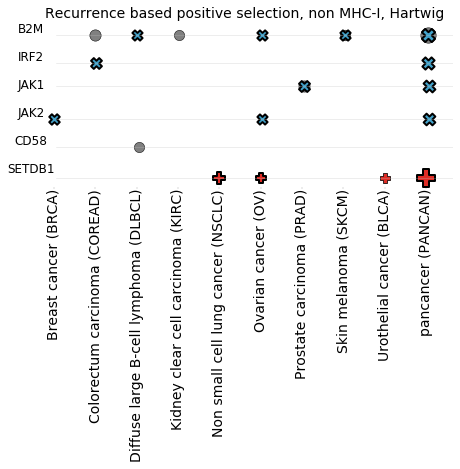

In [8]:
N=len(order)
fig,ax=plt.subplots(figsize=(N*0.75,len(genes)/2))

gs = gridspec.GridSpec(ncols=1,nrows=len(genes),wspace=0.0)
axis=[]
for j, gene in enumerate(genes):
    ax = plt.subplot(gs[j]) 
    ax.get_xaxis().set_visible(False)
    for i,ttype_s in enumerate(order):
        ttype_s=order[i]
        for k,talt in enumerate(["loh","mutation","deepdel","amp"]):
            marker=markers[talt]
            if (ttype_s,talt) in pivot.index:
                qvalues=-np.log10([10**-20 +x for x in  pivot.loc[(ttype_s,talt)][list(itertools.product(["qvalue"],[gene]))].values])
                colors=d_colors[talt]
                sizes=[s**1.3+100 if np.isfinite(s) else 0 for s in pivot.loc[(ttype_s,talt)][list(itertools.product(["n_obs"],[gene]))].values]
                lw=[get_lw(df_cnv_hmf,ttype_s,talt,g) for g in [gene] ]
                edgecolors="black"
                ax.scatter(x=[i for x in range(0,len(qvalues))],y=[0 for x in range(0,len(qvalues))],s=sizes,color=colors,edgecolors=edgecolors,linewidths=lw,clip_on=False,marker=marker)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_xticks([])
    ax.axhline(y=0,xmin=0.05,xmax=1.1,color="#C0C0C0",lw=0.55,alpha=0.5)
    ax.set_ylabel(gene,fontsize=12,rotation=0)
    #ax.set_ylabel(,fontsize=12,rotation=0,verticalalignment="center", labelpad=100)
    ax.set_yticks([])
    ax.set_xlabel("")
    axis.append(ax)

ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.get_xaxis().set_visible(True)
ax.set_xticks(list(range(0,len(order))))
ax.set_xticklabels([ttype_s.replace("__"," ") + " ("+codes[ttype_s.replace("__"," ")]+")" for ttype_s in order],rotation=90)
ax.tick_params(axis = 'both', labelsize =14  , pad=0.15,width=0.15, length = 1.5)
axis[0].set_title("Recurrence based positive selection, non MHC-I, Hartwig",fontsize=14)

plt.savefig("../../results/figures/figure5/positive_selection_hmf_nonmhcI.pdf", dpi=800,bbox_inches="tight")
plt.show()


# PCAWG

In [9]:
genes = ["HLA-A","HLA-B","HLA-C"]
order=sorted(list(set(df_pcawg[~df_pcawg["gene_name"].isin(genes)]["ttype"].values)))
alterations = ["mutation","loh","deepdel","amp"]
genes=set(df_pcawg[~df_pcawg["gene_name"].isin(genes)]["gene_name"].values)
genes

{'B2M', 'CALR', 'CD58', 'IRF2', 'JAK1', 'JAK2', 'SETDB1'}

In [10]:
genes  = ['B2M',"CALR",'IRF2', 'JAK1', 'JAK2',  'CD58', 'SETDB1']

In [11]:
pivot=df_pcawg.pivot_table(index=["ttype","type_alteration"],columns="gene_name",values=["qvalue","n_obs"])
counts = df_total[(df_total["is_selected"]==True)&(df_total["cohort"]=="PCAWG")]["cancer_type"].value_counts()
counts["pancancer"] = df_total[(df_total["is_selected"]==True)&(df_total["cohort"]=="PCAWG")].shape[0]
codes=df_total[(df_total["is_selected"]==True)][["cancer_type","cancer_type_code"]].drop_duplicates().set_index("cancer_type").to_dict()["cancer_type_code"]
codes["pancancer"] = "PANCAN"
codes["Kidney chromophobe cancer"] = "KICH"
d_colors = {"loh": "#a8ddb5", "deepdel": "#43a2ca", "amp": "#de2d26","mutation":"grey"}

### Plot

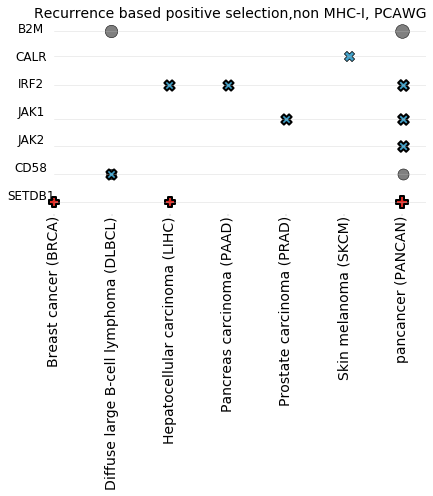

In [12]:
fig,ax=plt.subplots(figsize=(N*0.7,len(genes)/2))
N=len(order)
gs = gridspec.GridSpec(ncols=1,nrows=len(genes),wspace=0.0)
axis=[]
for j, gene in enumerate(genes):
    ax = plt.subplot(gs[j]) 
    ax.get_xaxis().set_visible(False)
    for i,ttype_s in enumerate(order):
        ttype_s=order[i]
        for k,talt in enumerate(["loh","mutation","deepdel","amp"]):
            marker=markers[talt]
            if (ttype_s,talt) in pivot.index:
                qvalues=-np.log10([10**-20 +x for x in  pivot.loc[(ttype_s,talt)][list(itertools.product(["qvalue"],[gene]))].values])
                colors=d_colors[talt]
                sizes=[s**1.3+100 if np.isfinite(s) else 0 for s in pivot.loc[(ttype_s,talt)][list(itertools.product(["n_obs"],[gene]))].values]
                lw=[get_lw(df_cnv_pcawg,ttype_s,talt,g) for g in [gene] ]
                edgecolors="black"
                ax.scatter(x=[i for x in range(0,len(qvalues))],y=[0 for x in range(0,len(qvalues))],s=sizes,color=colors,edgecolors=edgecolors,linewidths=lw,clip_on=False,marker=marker)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_xticks([])
    ax.axhline(y=0,xmin=0.05,xmax=1.1,color="#C0C0C0",lw=0.55,alpha=0.5)
    ax.set_ylabel(gene,fontsize=12,rotation=0)
    #ax.set_ylabel(,fontsize=12,rotation=0,verticalalignment="center", labelpad=100)
    ax.set_yticks([])
    ax.set_xlabel("")
    axis.append(ax)

ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.get_xaxis().set_visible(True)
ax.set_xticks(list(range(0,len(order))))
ax.set_xticklabels([ttype_s.replace("__"," ") + " ("+codes[ttype_s.replace("__"," ")]+")" for ttype_s in order],rotation=90)
ax.tick_params(axis = 'both', labelsize =14  , pad=0.15,width=0.15, length = 1.5)
axis[0].set_title("Recurrence based positive selection,non MHC-I, PCAWG",fontsize=14)

plt.savefig("../../results/figures/figure5/positive_selection_pcawg_nonmhcI.pdf", dpi=800,bbox_inches="tight")
plt.show()


# Select plots of CNV positive selection examples, perform the visualization with customized genomic intervals

In [53]:
import os
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from scipy import stats
import statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
import click
import pybedtools
import glob
from IPython.display import IFrame


import math
def orderOfMagnitude(number):
    return math.floor(math.log(number, 10))

def plot_ttype_zoom(res,annotations_info, i, ttype, list_chunks, output_dir_plots,name_run):

    # calculate coordinates...
    xs, ys, xticks, xticklabels, annotations, pvalue, odds_ratio,y_top,y_bottom = [], [], [], [], [], [], [], [], []
    d = []
    for j, x in enumerate(list_chunks):
        o = res.loc[x]
        xs.append(o["n_observed"])
        ys.append(o["n_mean_simulated"])
        y_top.append(o["Q3_simulated"])
        y_bottom.append(o["Q1_simulated"])

        if x in annotations_info:
            genes=i.loc[x]["gene"]
            if not(isinstance(genes,str)):
                genes=";".join(list(i.loc[x]["gene"]))
            annotations.append((j, xs[-1] + 1,genes ))
            #.append([ttype, i.loc[x]["gene"],x, o["pvalue_ana_global"], o["q_value_ana"], o["odds_ratio"], xs[-1], ys[-1]])

        xticks.append(j)
        if j % 10 == 0:
            
            s=int(x.split("_")[1].split("-")[0])
            mg=6
            e=int(x.split("_")[1].split("-")[1])
            label="{:.1f}".format(s/10**mg) + "-" + "{:.1f}".format(e/10**mg)
            xticklabels.append(label)
        else:
            xticklabels.append("")
    
    # plot ttype
    typer = name_run.split("_")[1]
    d_colors = {"loh": "#a8ddb5", "deepdel": "#43a2ca", "amp": "#de2d26"}
    color = d_colors[typer]
    fig, ax = plt.subplots(figsize=(20, 5))
    plt.plot(xs, color=color)
    ax.fill_between(range(0, len(xs)), xs, color=color)
    plt.plot(ys, color="black")
    ax.fill_between(y_bottom, y_top, color="black", alpha=0.2)
    max_value = int(np.nanmax(xs)+5)
    ax.set_ylim(0,max_value)
    for (x, y, s) in annotations:
        if len(s)==2:
            s=s[0]
        ax.annotate(xy=(x, y-1), s=s,fontsize=16)
        ax.axvline(x=x,ymin=0,ymax=y,ls="--",lw=0.5,color="grey")
    # ax.fill_between(range(0,len(xs)),ys,color="#999999")
    ax.set_xticks(xticks)
    _ = ax.set_xticklabels(xticklabels, rotation=90)
    ax.set_title(ttype, fontsize=18)
    name = "Number of samples"
    if "deepdel_focal" in name_run:
        name = "Number of samples with focal allelic deepdel "
    elif "deepdel_hfocal" in name_run:
        name = "Number of samples with highly focal allelic deepdel"
    elif "deepdel_nonfocal" in name_run:
        name = "Number of samples with allelic deepdel"
    ax.set_ylabel(name,fontsize=16)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axhline(y=np.nanmean(ys),xmin=0,xmax=(len(xs)),ls="--",color="black")
    ax.tick_params(axis='both', which='major', labelsize=16)
    plt.savefig(f'{output_dir_plots}/{ttype}_{name_run}_zoom.pdf', dpi=800, bbox_inches="tight")
    
    plt.show()
    plt.close()

def run(df_chunks, list_chunks_specific, highlight_genes, input_file):
    # path genes
    df_genes = pd.read_csv(
        "../../external_data/selected_regions.tsv",
        sep="\t")
    df_genes_s = df_genes[df_genes["gene"].isin(highlight_genes)]
    query = pybedtools.BedTool.from_dataframe(df_chunks[["chromosome", "start", "end", "name"]])
    regions = pybedtools.BedTool.from_dataframe(df_genes_s[["chromosome", "start", "end", "gene"]])
    i = query.intersect(regions, wao=True, loj=True).to_dataframe()
    i.columns = ["chr_i", "start_i_q", "end_i_q", "name", "chr_i_r", "start_i_r", "end_i_r", "gene", "length"]
    i = i[i["gene"] != "."]
    i.set_index("name", inplace=True)

    name_run = os.path.dirname(input_file).split("/")[-1]
    ttype = os.path.basename(input_file).split(".")[-3]
    res = pd.read_csv(input_file,sep="\t")
    res.set_index("region", inplace=True)
    
    annotations_info_specific = set(i[i["gene"].isin(highlight_genes)].index)
    
    plot_ttype_zoom(res, annotations_info_specific, i[i["gene"].isin(highlight_genes)], ttype, list_chunks_specific, "../../results/figures/figure5/", name_run+"_"+highlight_genes[0])


### B2M - pancancer

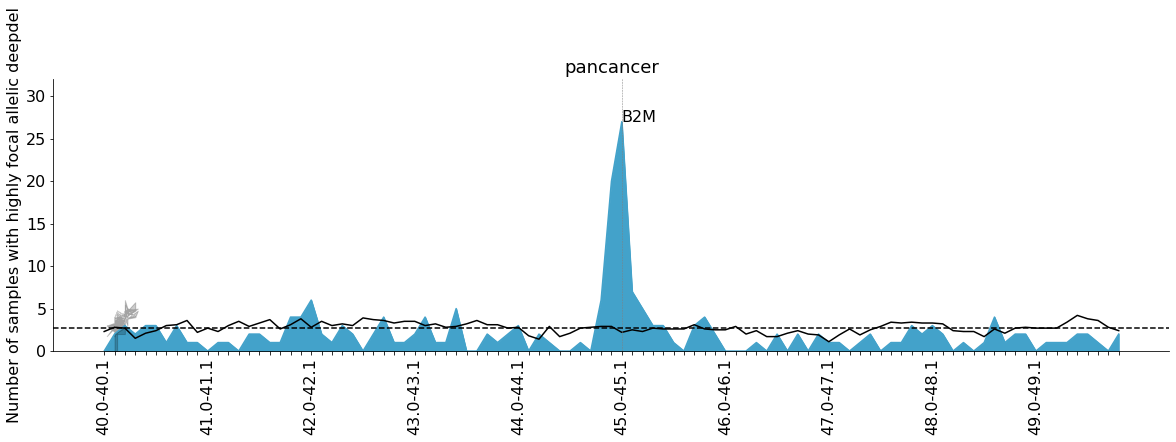

In [54]:
chunks_representation="../../external_data/regions_kb.tsv.gz"
input_file = "/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/hmf/positive_selection/cnv/ignore_deepdel_hfocal/pancancer.tsv.gz"
genes = ["B2M"]
df_chunks = pd.read_csv(chunks_representation, sep="\t")
df_chunks["chromosome"] = df_chunks["chromosome"].astype(int)
list_chunks_specific = list(df_chunks[(df_chunks["chromosome"]==15)&(df_chunks["start"]>40000000)&(df_chunks["end"]<50000000)]["name"].values) # B2M, region of interest

run(df_chunks,list_chunks_specific,genes,input_file)

In [55]:
np.log2(9.852869	)

3.3005438757765933

In [56]:
df_cnv_hmf

,ttype,gene,type_alteration,region,q_value_ana_global,odds_ratio_global,n_obs,n_sim,mean_global,focal
0,Breast__cancer,JAK2,deepdel,chr9_5000001-5100000,1.638807e-03,12.835132,6,0.6,0.645068,"hfocal,focal"
1,Cervix__carcinoma,HLA-A,loh,chr6_29900001-30000000,3.623937e-02,2.650135,14,6.3,5.282750,focal
2,Cervix__carcinoma,HLA-B,loh,chr6_31300001-31400000,1.278601e-02,2.839430,15,6.2,5.282750,focal
3,Cervix__carcinoma,HLA-C,loh,chr6_31200001-31300000,1.278601e-02,2.839430,15,6.3,5.282750,focal
4,Colorectum__carcinoma,HLA-A,loh,chr6_29900001-30000000,7.611535e-02,2.174080,17,6.7,7.819398,hfocal
5,Colorectum__carcinoma,IRF2,deepdel,chr4_185300001-185400000,9.155631e-09,31.076011,9,0.4,0.333633,"hfocal,focal"
6,Diffuse__large__B-cell__lymphoma,B2M,deepdel,chr15_45000001-45100000,2.228786e-04,255.070796,3,0.0,0.018634,"hfocal,focal"
7,Non__small__cell__lung__cancer,SETDB1,amp,"chr1_150800001-150900000,chr1_150900001-151000000",4.468130e-07,6.396106,17,2.7,2.657867,"hfocal,focal"
8,Ovarian__cancer,B2M,deepdel,chr15_45000001-45100000,6.481895e-03,32.917999,4,0.1,0.157215,"hfocal,focal"
9,Ovarian__cancer,JAK2,deepdel,chr9_4900001-5000000,9.498565e-02,24.688499,3,0.1,0.121514,hfocal


In [17]:
np.log2(9.857225	)

3.3011815571291456

### SETDB1 - NSCLC

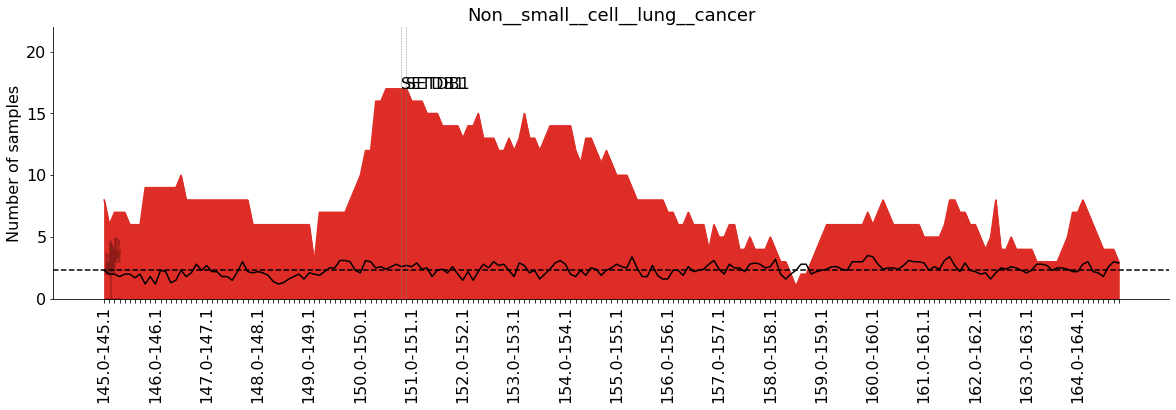

In [57]:
chunks_representation="../../external_data/regions_kb.tsv.gz"
input_file = "/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/hmf/positive_selection/cnv/ignore_amp_focal/Non__small__cell__lung__cancer.tsv.gz"
genes = ["SETDB1"]
df_chunks = pd.read_csv(chunks_representation, sep="\t")
df_chunks["chromosome"] = df_chunks["chromosome"].astype(int)
list_chunks_specific = list(df_chunks[(df_chunks["chromosome"]==1)&(df_chunks["start"]>145000000)&(df_chunks["end"]<165000000)]["name"].values) # SETDB1

run(df_chunks,list_chunks_specific,genes,input_file)

In [58]:
np.log2(6.396106)

2.677193848200224